<a href="https://colab.research.google.com/github/aunz/ds/blob/master/Fashion_Articles_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognising Fashion Articles with Convolution Neural Network (CNN)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # graphs

from keras.datasets import fashion_mnist

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, SeparableConv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Flatten, Dropout, InputLayer
from keras.optimizers import Adam, Adamax, RMSprop
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [0]:
# load the data
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()


# reshape and normalise the data

X_train = X_train.reshape(-1, 28, 28, 1) / 255
y_train = to_categorical(y_train)

X_test = X_test.reshape(-1, 28, 28, 1) / 255
y_test = to_categorical(y_test)

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f'''Shapes
X_train: {X_train.shape};\ty_train: {y_train.shape}
X_test: {X_test.shape};\ty_test: {y_test.shape}''')

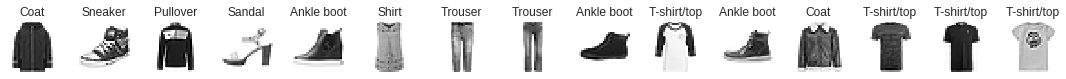

In [4]:
# check out some random images
plt.figure(figsize=(15, 2))
for i, n in enumerate(np.random.choice(range(60000), 15)):
    plt.subplot(1, 15, i + 1)
    plt.imshow(X_train[n].reshape(28, 28), cmap='binary')
    plt.xticks(())
    plt.yticks(())
    plt.title(labels[np.argmax(y_train[n])])

plt.tight_layout()

In [0]:
from copy import deepcopy

def train(make_model, n = 5, optimizer = lambda: 'rmsprop', callbacks = lambda: [EarlyStopping(patience=3, verbose=1)], verbose=0):
    # given a model, train it for n times and plot the associated metrics
    # make_model, optimizer and callbacks should be provided as a function as each time the functions are called, brand new instances are created in the for loop below. Because can't use deepcopy

    models = [] # to hold the model weights
    hists = [] # contains all the history
    
    make_model(None).summary()
    
    plt.figure(figsize=(4 * (n + 2), 8)) # the figure

    for i in range(n):
        model = make_model(i)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer(), metrics=['accuracy'])
        hist = model.fit(X_train, y_train, batch_size=256, epochs=50, validation_data=(X_test,y_test), callbacks=callbacks(), verbose=verbose)        
        hists.append(hist)
        
        models.append(model) # store the model
#         model.set_weights(initial_weights) # restore to the original weights

        r = range(2, len(hist.history['acc']) + 1) # starting from epoch 2, ignore the first epoch
        plt.subplot(2, n + 1, i + 2) # plot the loss history, starting with subplot 3
        plt.plot(r, hist.history['loss'][1:], '.-', label='Train loss') # ignore the first epoch
        plt.plot(r, hist.history['val_loss'][1:], '.-', label='Val loss')
        plt.legend()
        
        plt.subplot(2, n + 1, i + 2 + n + 1) # plot the acc history, starting with subplot 3
        plt.plot(r, hist.history['acc'][1:], '.-', label='Train acc')
        plt.plot(r, hist.history['val_acc'][1:], '.-', label='Val acc')
        plt.legend()

    
    plt.subplot(2, n + 1, 1) # plot the loss summary at the first subplot
    metrics = ['loss'] * n + ['val_loss'] * n 
    values = np.concatenate([
        [i.history['loss'][-1] for i in hists],
        [i.history['val_loss'][-1] for i in hists],
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Loss')
    values = values.reshape(2, -1)
    print('Loss', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))
    
    plt.subplot(2, n + 1, n + 2) # plot the acc summary at the second subplot
    metrics = ['acc'] * n + ['val_acc'] * n
    values = np.concatenate([
        [i.history['acc'][-1] for i in hists],
        [i.history['val_acc'][-1] for i in hists]
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Accuracy')
    values = values.reshape(2, -1)
    print('\nAcc', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))

    plt.tight_layout()
    
    return models, hists

### Trial 0

Firstly, we try normal neural networks with 2 hidden layers, each with 64 neurons

We got a mean accuary of 0.8823 and 0.8543 for the train and test set respectively.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 28, 28, 64)        128       
_________________________________________________________________
dense_172 (Dense)            (None, 28, 28, 64)        4160      
_________________________________________________________________
flatten_88 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_173 (Dense)            (None, 10)                501770    
Total params: 506,058
Trainable params: 506,058
Non-trainable params: 0
_________________________________________________________________
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00010: early stopping
Epoch 00006: early stopping
Loss [0.33862473 0.33099941 0.33811655 0.31879514 0.35759208] [0.45829703 0.42392481 0.4865204  0.5003566  0.45315282]
Mean [0.3

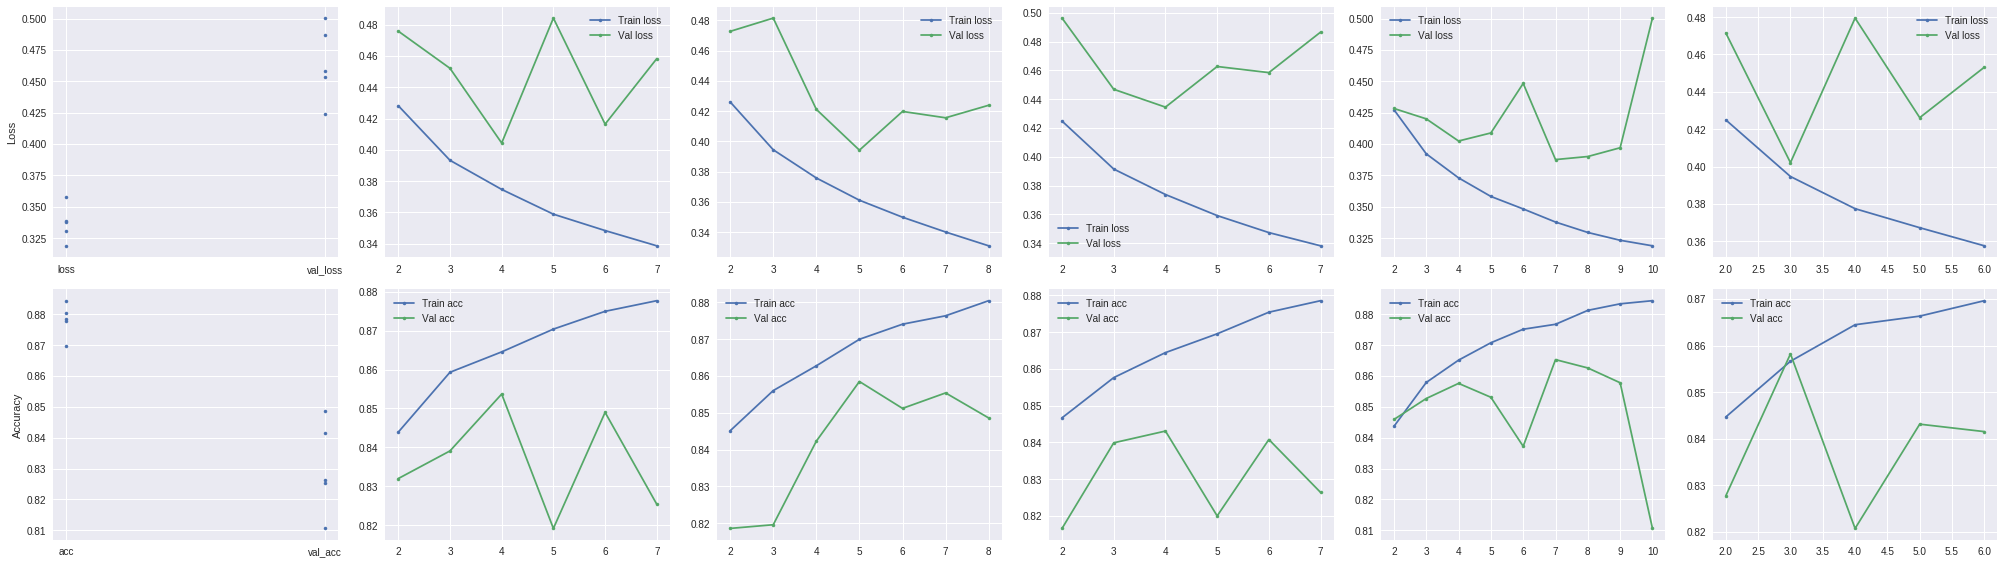

In [46]:
# Try just normal neural networks with 2 hidden layers, each with 64 neurons
%%time

train(lambda x: Sequential([
    Dense(64, input_shape=(28, 28, 1), activation='relu'),
    Dense(64, activation='relu'),
    Flatten(),
    Dense(10, activation='softmax')
]));

### Trial 1

Now try with the most basic Convolution network, with just 1 convolution layer with the default kernel size of 3 and stride of 1.

I find the animations in http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html explain kernel size, stride and padding very well!

We obtained a mean accuracy of 0.9332 (train) and 0.8967 (test). Much better than the normal neural network.



In [42]:
Sequential([
    Conv2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='softmax')    
]).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_184 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_87 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_170 (Dense)            (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


In [77]:
# now try with Convolution, the most basic setup
%%time

# models, hists = train(lambda x: Sequential([
#     Conv2D(32, kernel_size=3, strides=1, activation='relu', input_shape=(28, 28, 1)),
#     Flatten(),
#     Dense(10, activation='softmax')    
# ]));

models2[0].get_weights()[0]

CPU times: user 6.55 ms, sys: 2 µs, total: 6.55 ms
Wall time: 6.28 ms


array([[ 0.00386547, -0.01992116,  0.20006515,  0.17739663,  0.22772956,
         0.16911955,  0.30294085, -0.1485105 , -0.03139208, -0.12514262,
        -0.24218261, -0.12259154, -0.21040489,  0.21770091, -0.01659802,
         0.23720714, -0.29009017, -0.12178952,  0.3084076 , -0.00430629,
        -0.16178794, -0.2367271 , -0.13905889, -0.22112378,  0.18122825,
        -0.14749545, -0.29793516, -0.0496344 , -0.16120708,  0.32030514,
         0.00709941, -0.00461906,  0.16687602, -0.02598271, -0.1596586 ,
         0.10255996, -0.09266481,  0.19914947, -0.06882261, -0.21012992,
        -0.00052893,  0.02679881, -0.21280435, -0.09589896, -0.12560368,
         0.18508653, -0.2727537 , -0.06559207,  0.24068032, -0.02772501,
         0.18126787,  0.17406313,  0.40480775, -0.26050723,  0.37915584,
         0.3028085 ,  0.3025615 ,  0.30995736,  0.08280743,  0.0212094 ,
         0.38304144, -0.03830832, -0.0282988 , -0.2530931 ]],
      dtype=float32)

### Trial 2
Changed the strides to 2

It doesn't seem to improve anything

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 13, 13, 32)        320       
_________________________________________________________________
flatten_3 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                54090     
Total params: 54,410
Trainable params: 54,410
Non-trainable params: 0
_________________________________________________________________
Epoch 00016: early stopping
Epoch 00017: early stopping
Epoch 00016: early stopping
Epoch 00012: early stopping
Epoch 00011: early stopping
Loss [0.23576201 0.23307949 0.23701177 0.25558923 0.26133085] [0.30884161 0.30112567 0.31132829 0.3374401  0.32072523]
Mean [0.24455467 0.31589218] Std [0.01156795 0.01246002]
Acc [0.9171     0.91783333 0.91673333 0.90956667 0.90741667] [0.8884 0.8913 0.8905 0.8

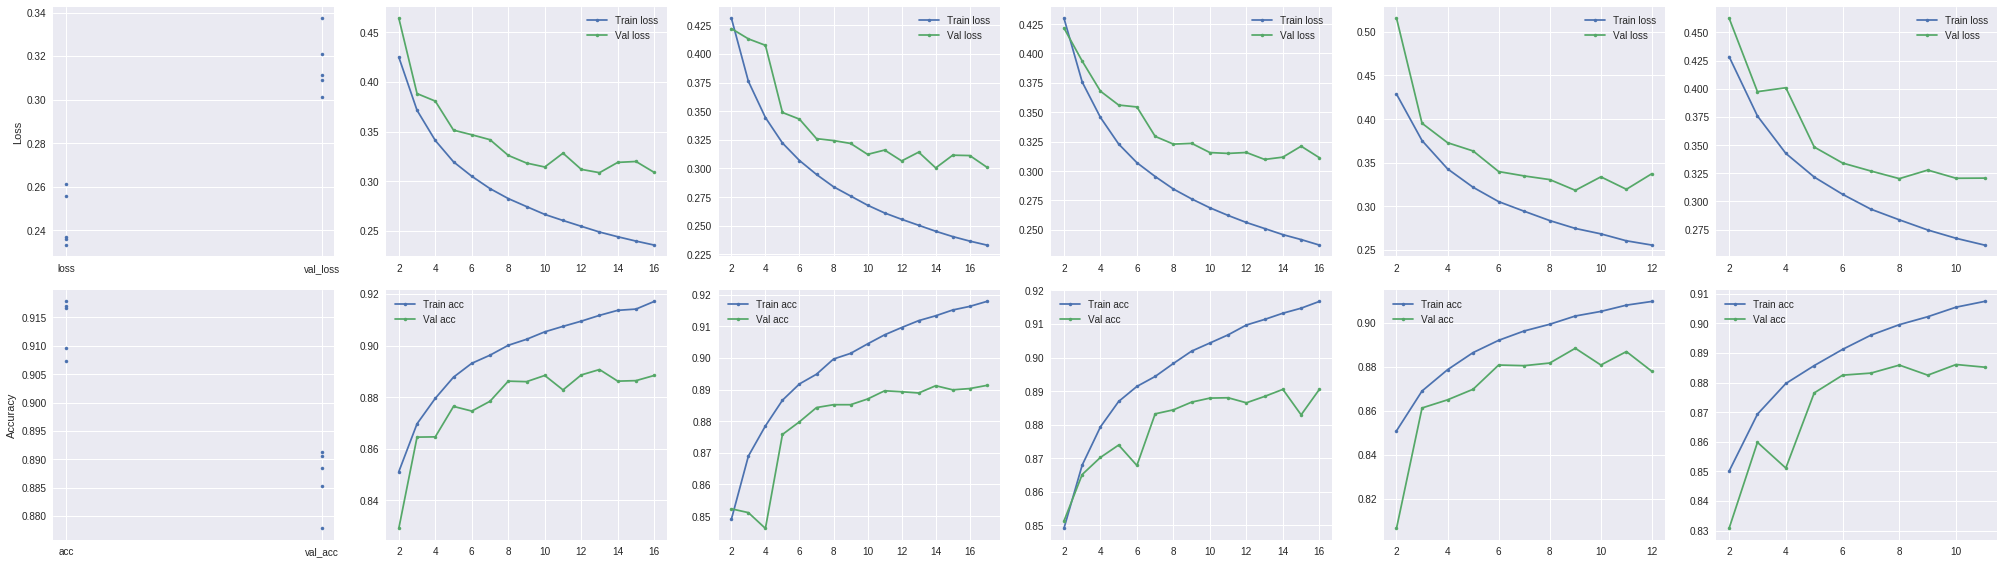

In [8]:
# increase the stride to 2
%%time
train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, strides=2, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='softmax')
]));

### Trial 3
Set the padding to "same".

It doesn't seem to improve anything either.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
flatten_31 (Flatten)         (None, 6272)              0         
_________________________________________________________________
dense_50 (Dense)             (None, 10)                62730     
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
_________________________________________________________________
Epoch 00014: early stopping
Epoch 00018: early stopping
Epoch 00016: early stopping
Epoch 00020: early stopping
Epoch 00014: early stopping
Loss [0.25080241 0.2313212  0.24189907 0.22126721 0.2507836 ] [0.3202025  0.31222611 0.33909668 0.30562652 0.32476935]
Mean [0.2392147  0.32038423] Std [0.01148686 0.01143471]
Acc [0.91103333 0.91881667 0.91481667 0.9219     0.91095   ] [0.8874 0.8915 0.8781 0.8

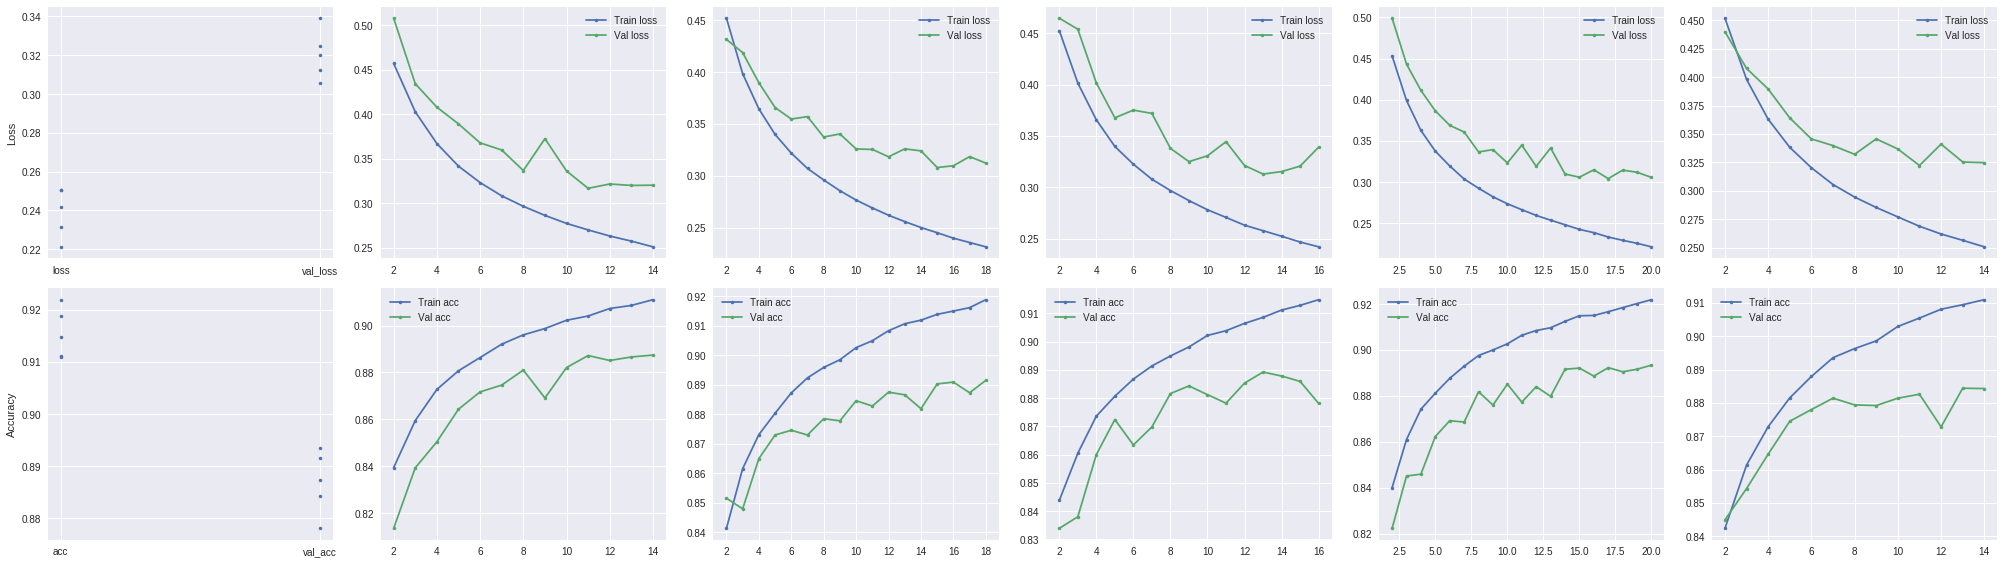

In [46]:
# set padding to 'same'
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(10, activation='softmax')
]));

### Trial 4
Add another Dense layer

Average accuracies have increased for both train and test set. There are now over 2.7 millions trainable params.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_79 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
flatten_32 (Flatten)         (None, 21632)             0         
_________________________________________________________________
dense_51 (Dense)             (None, 128)               2769024   
_________________________________________________________________
dense_52 (Dense)             (None, 10)                1290      
Total params: 2,770,634
Trainable params: 2,770,634
Non-trainable params: 0
_________________________________________________________________
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping
Loss [0.12686194 0.11044483 0.11176495 0.08427913 0.11425852] [0.29156072 0.32207396 0.30249613 0.31388811 0.28691212]
Mean 

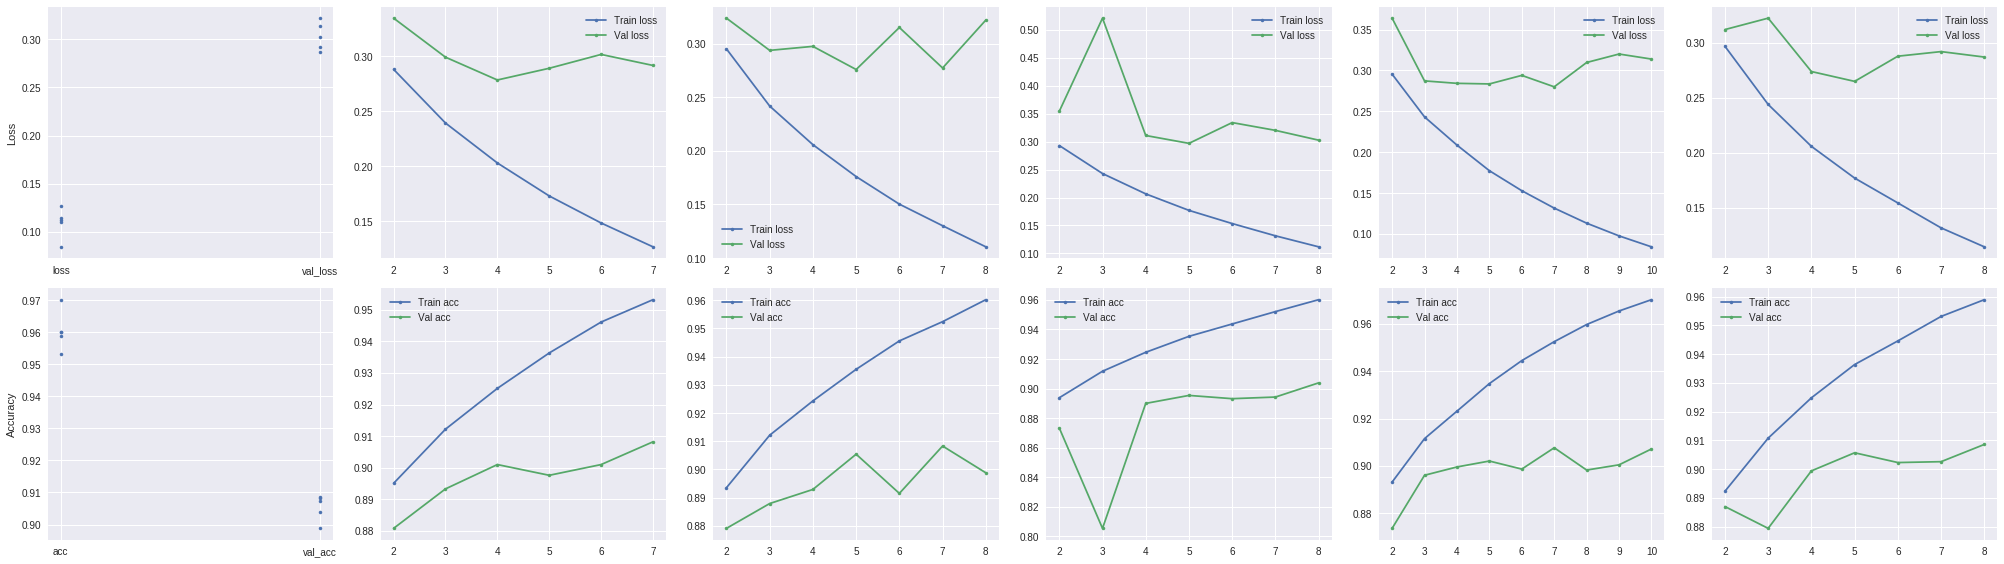

In [47]:
# Add another Dense layer
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(128, activation='relu'), # I just chose 128 randomly
    Dense(10, activation='softmax')
]));

### Trial 5
Increase the number of filter in the first Conv2D layer, from 32 to 64

The trainable param number is now over 5 millions! There isn't much improvement though.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
flatten_33 (Flatten)         (None, 43264)             0         
_________________________________________________________________
dense_53 (Dense)             (None, 128)               5537920   
_________________________________________________________________
dense_54 (Dense)             (None, 10)                1290      
Total params: 5,539,850
Trainable params: 5,539,850
Non-trainable params: 0
_________________________________________________________________
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00008: early stopping
Epoch 00008: early stopping
Epoch 00009: early stopping
Loss [0.08212663 0.10727052 0.0859035  0.09086804 0.07364564] [0.38037102 0.29732327 0.32941196 0.38115628 0.31708589]
Mean 

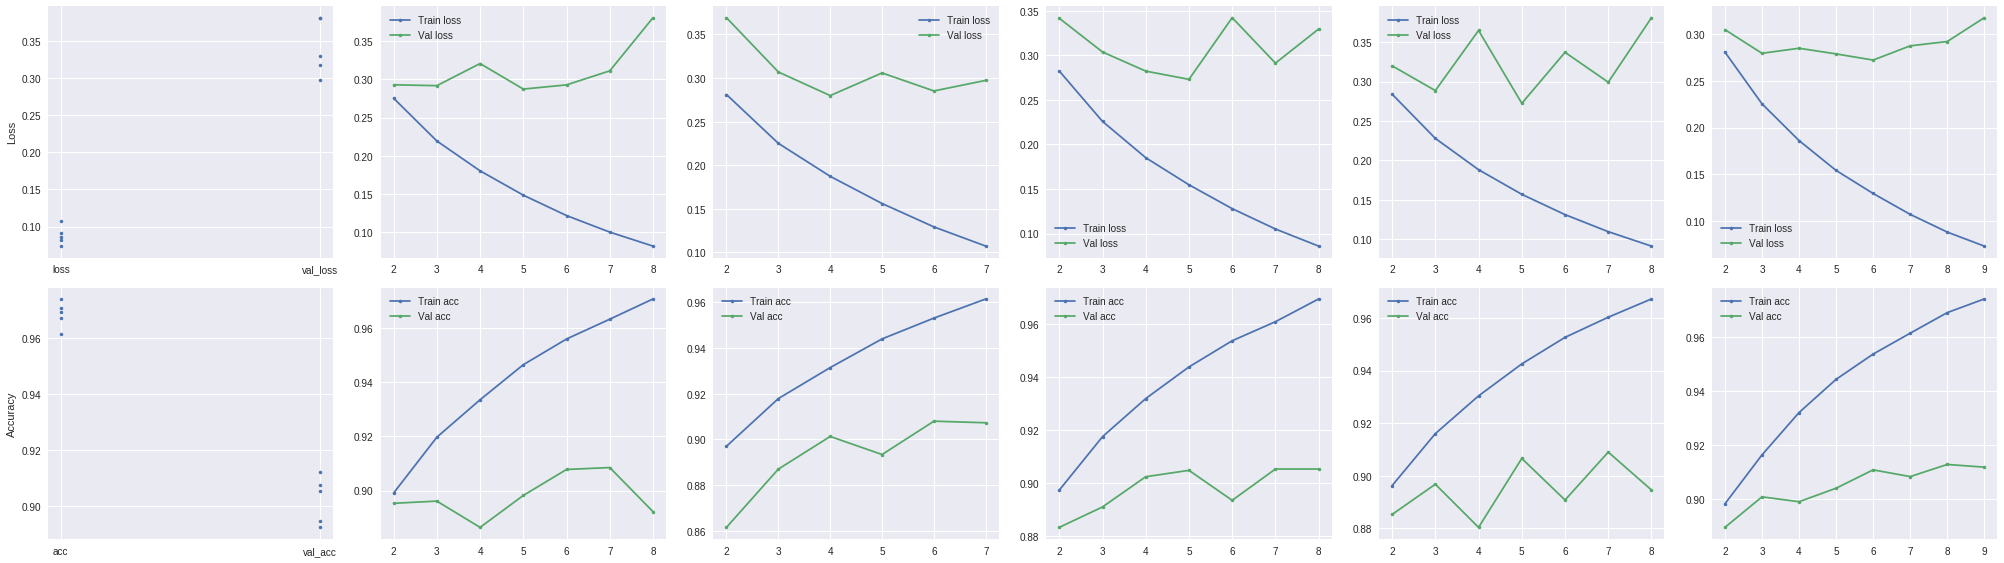

In [48]:
# more filters in the first Conv2D layer, from 32 to 64
%%time

train(lambda x: Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
]));

### Trial 6
Add a MaxPooling. This reduces the trainable params to about 700K.

Not too much improvement though.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_56 (Dense)             (None, 10)                1290      
Total params: 693,962
Trainable params: 693,962
Non-trainable params: 0
_________________________________________________________________
Epoch 00009: early stopping
Epoch 00013: early stopping
Epoch 00012: early stopping
Epoch 00011: early stopping
Epoch 00012: early stopp

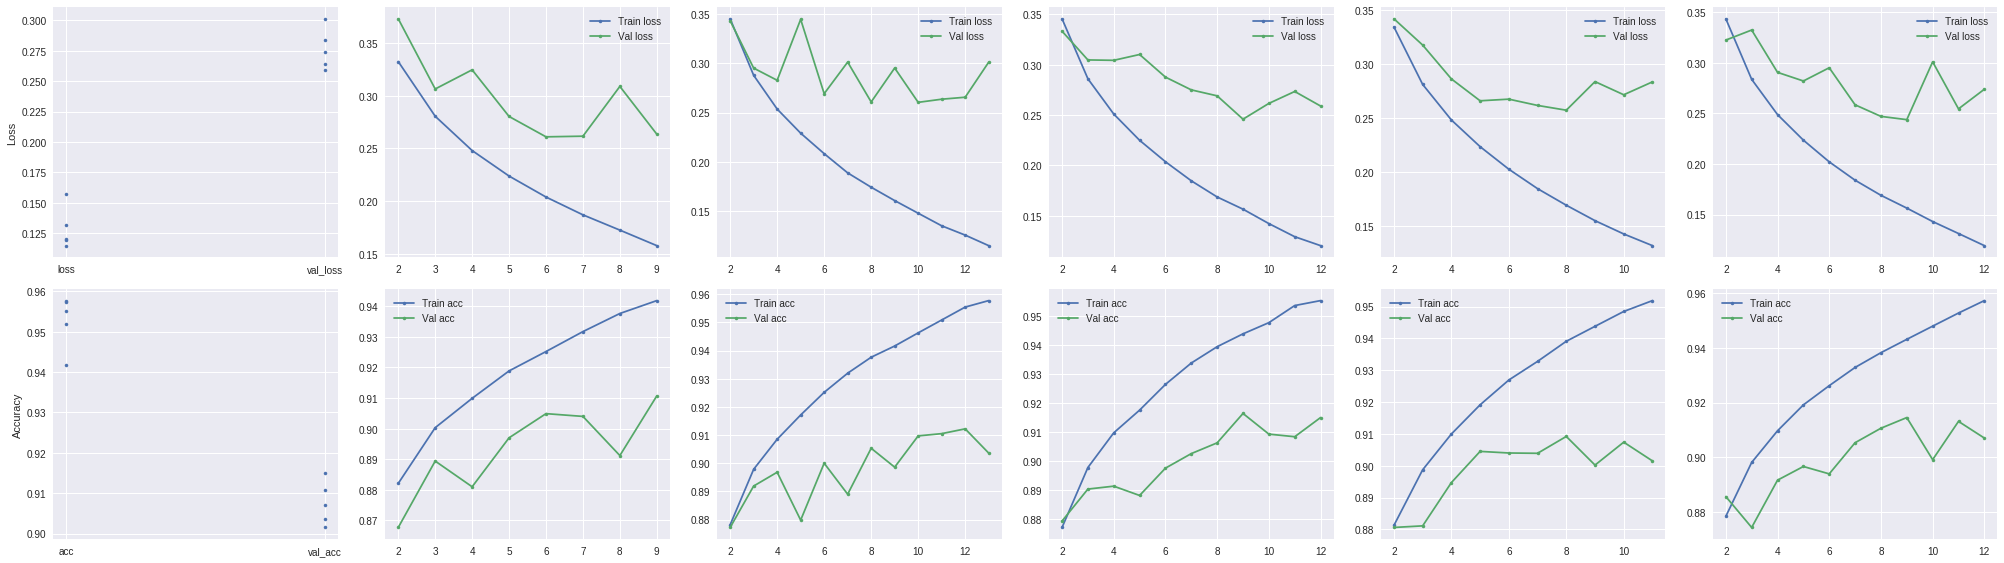

In [49]:
# add MaxPooling
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
]));

### Trial 7
Add BatchNormalization, this helps with weights and faster training.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_54 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
flatten_35 (Flatten)         (None, 5408)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 128)               692352    
_________________________________________________________________
dense_58 (Dense)             (None, 10)                1290      
Total para

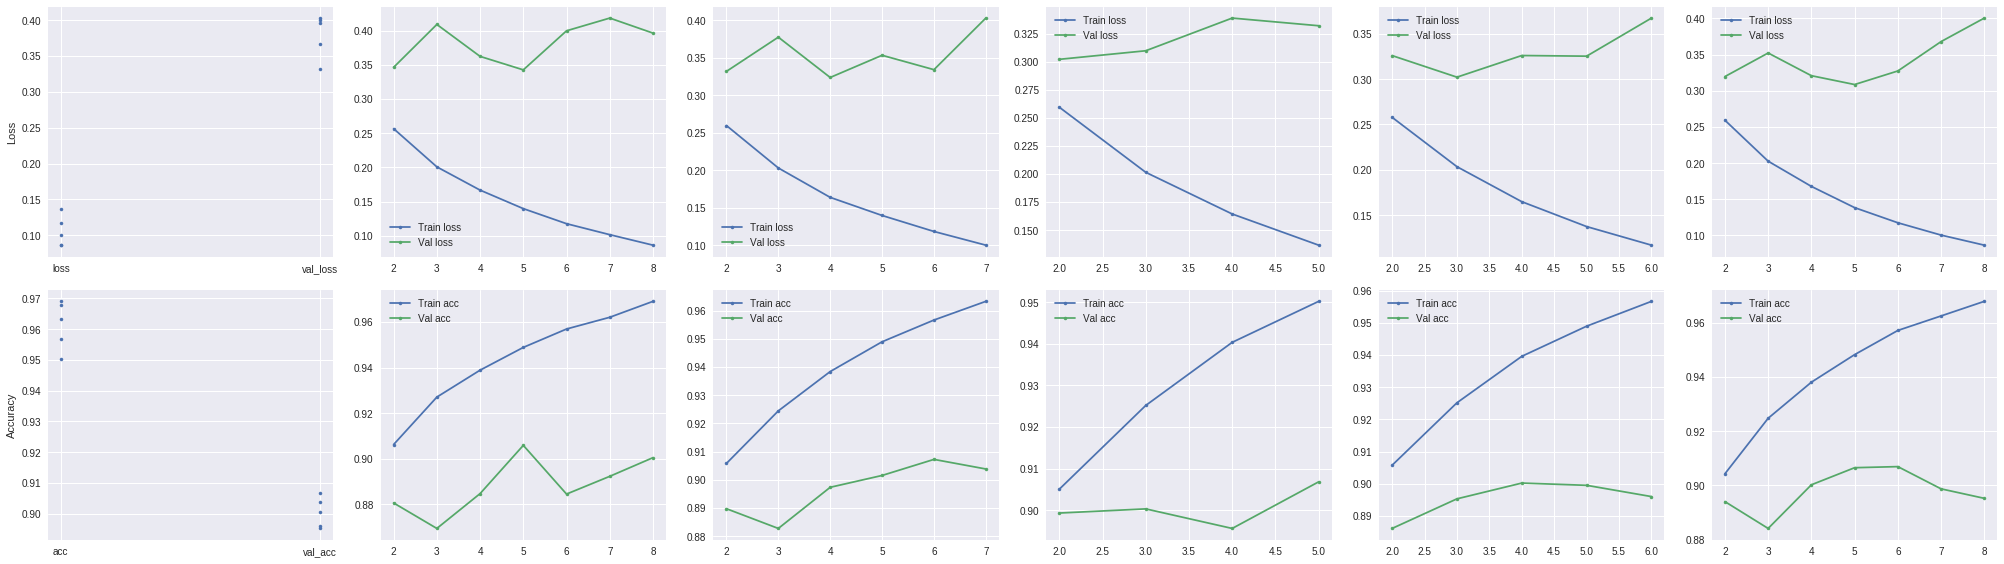

In [50]:
# add Batchnormalisation, to help with normalising weights 
%%time

train(lambda x: Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    BatchNormalization(),
    MaxPooling2D(),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
]));

### Trial 8
Add 1 more set of Conv2D, Batch, MaxPooling

Doesn't seem to help with accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_56 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization_57 (Batc (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_58 (Batc (None, 11, 11, 32)        128       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 5, 5, 32)          0         
__________

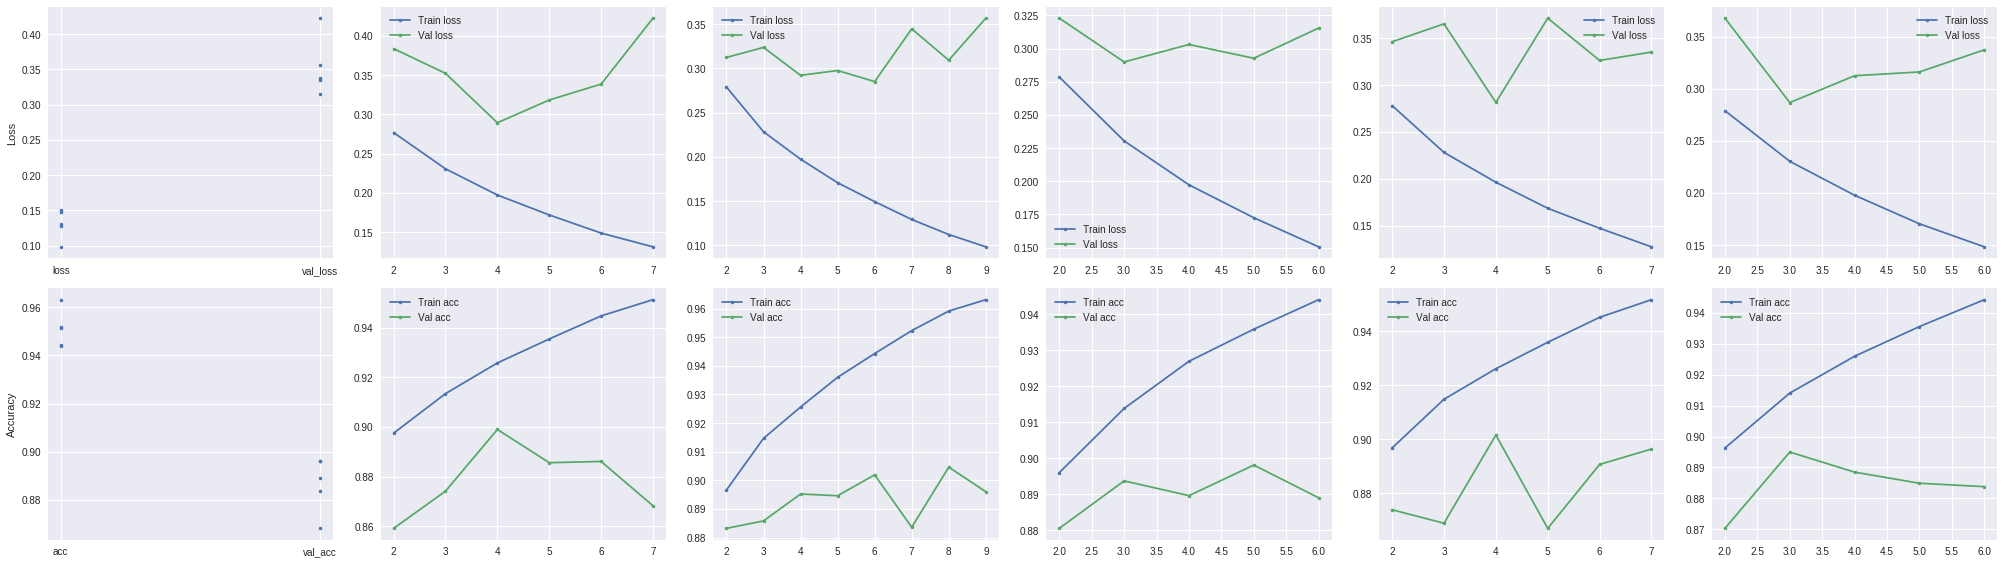

In [51]:
# add more Conv2D
%%time

def make_mode(x):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(32, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model);

### Trial 9
3 layers of Conv2D with increasing kernel size

A slight improvement. Mean train accuracy reaches 0.97 while mean test accuracy stays at ~0.90, it's a sight of overfitting.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_15 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
flatten_9 (Flatten)          (None, 11552)             0         
__________

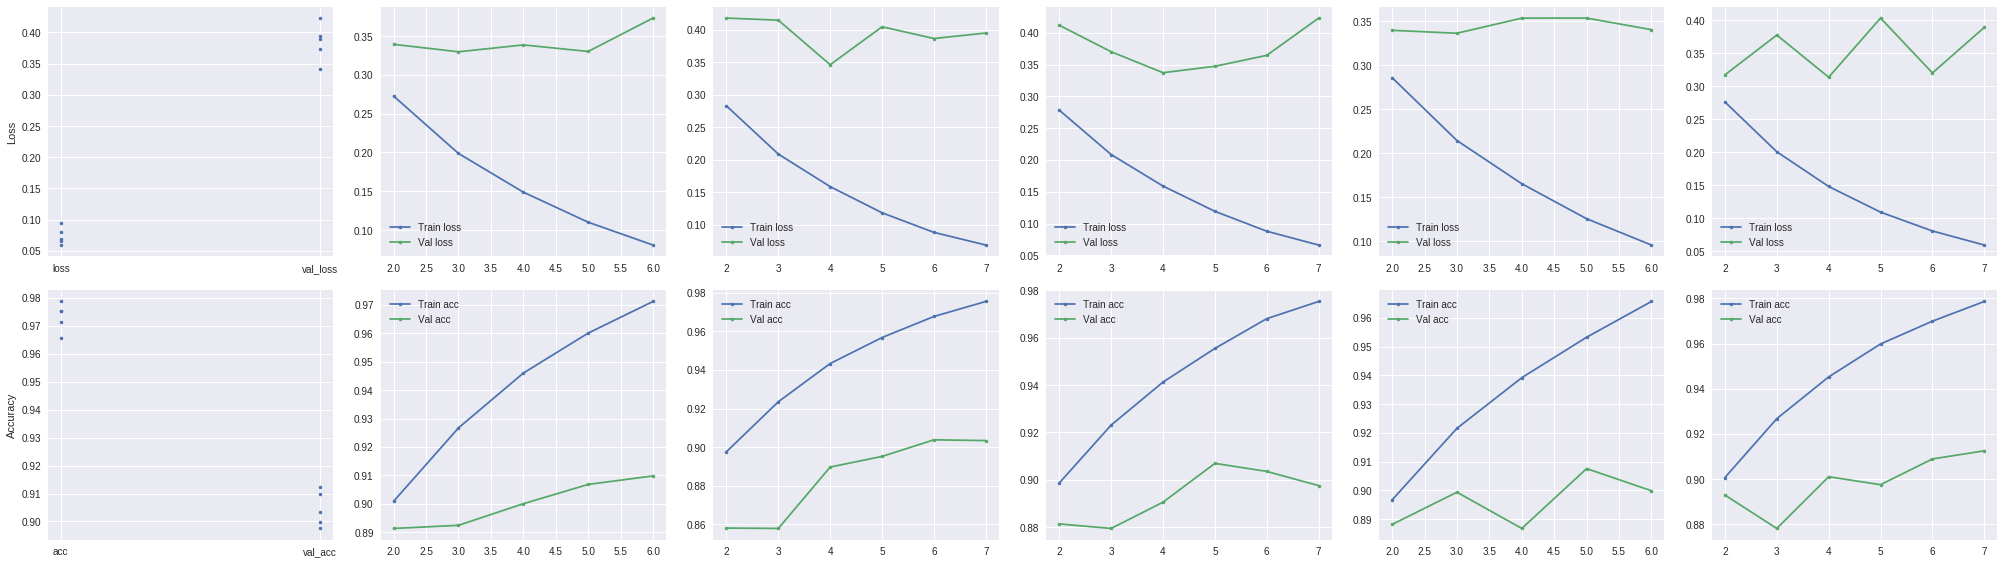

In [14]:
# 3 layers of Conv2D with increasing kernel size
%%time
def make_model(_):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

train(make_model);

### Trial 9b
Use Adam optimizer and ReduceLROnPlateau as callbacks

Seem to help a bit with accuracy

Now the train accuracy ~0.99, the test ~0.91, still overfitted.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_43 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_44 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_45 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
flatten_36 (Flatten)         (None, 11552)             0         
__________

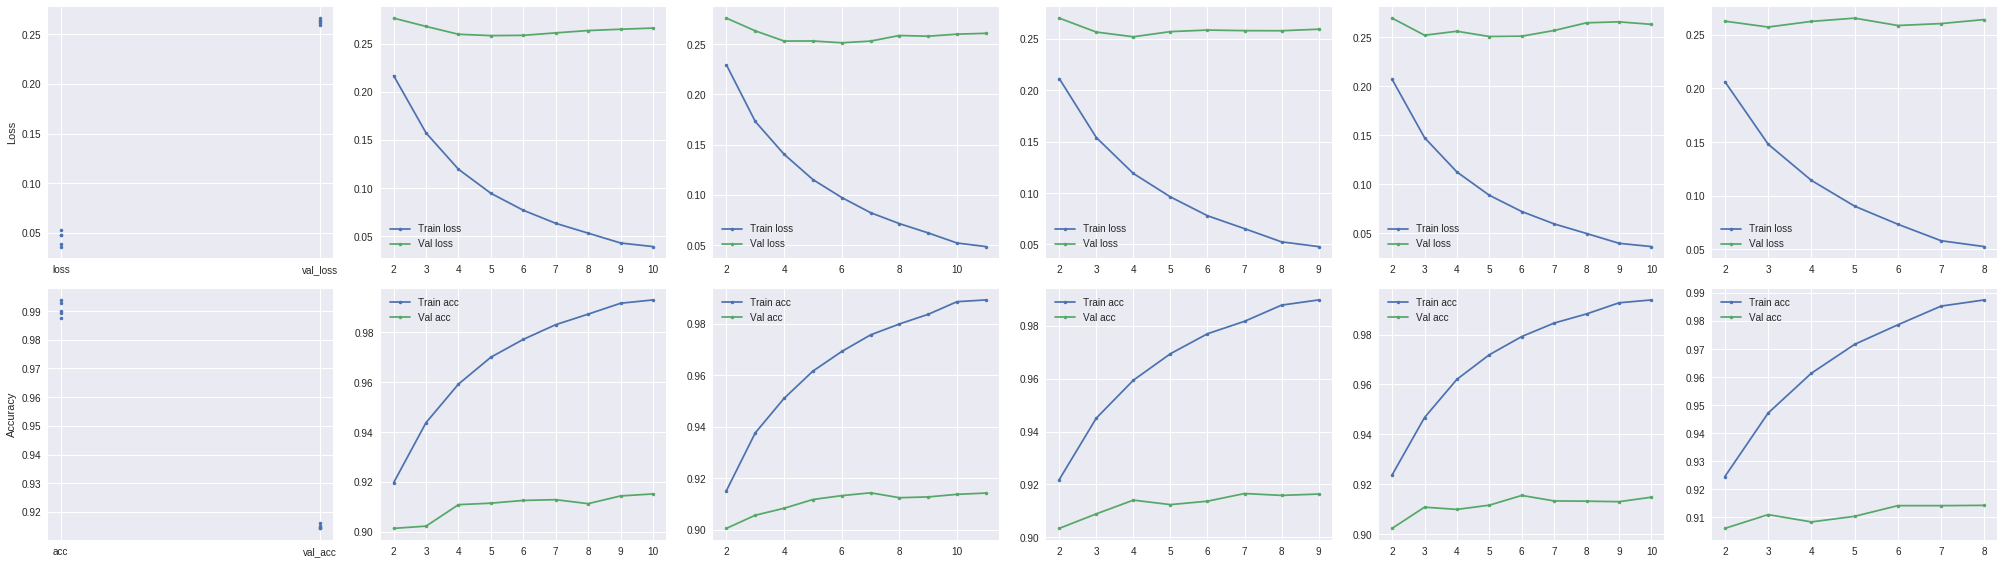

In [25]:
# 3 layers of Conv2D with increasing kernel size, change the optimiser to Adam and callbacks to use reducing rate
%%time
def make_model(_):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    return model

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]
train(make_model, optimizer=lambda: Adam(decay=0.01), callbacks=callbacks, verbose=1);

### Trial 10
Add Dropout layers

It reduces mean accuracy in train, but doesn't improve it in test

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_61 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_62 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_63 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
dropout_19 (Dropout)         (None, 19, 19, 32)        0         
__________

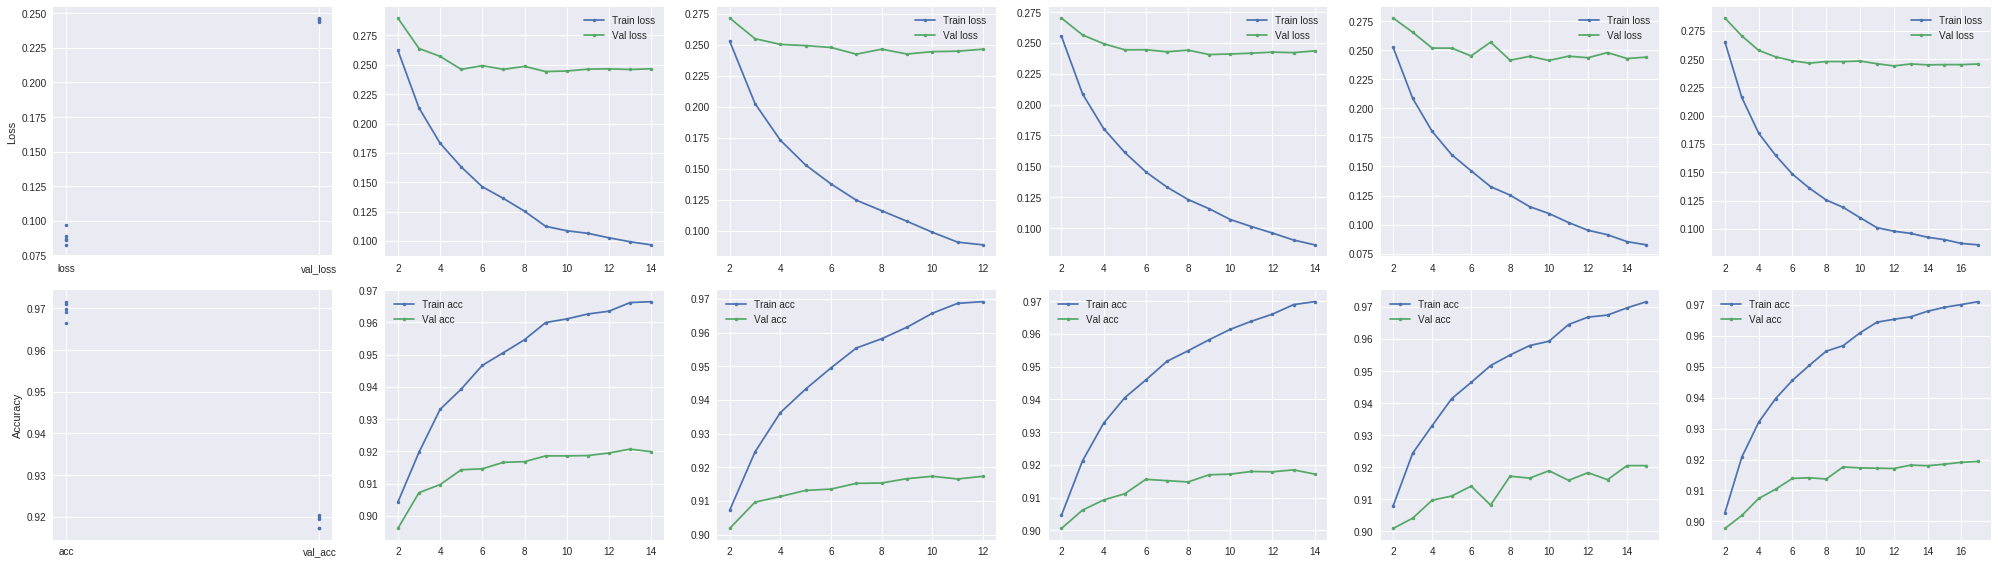

In [26]:
# Add Dropout
%%time

def make_model(x):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    return model

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]
train(make_model, optimizer=lambda: Adam(decay=0.01), callbacks=callbacks, verbose=1);

### Trial 11

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_160 (Conv2D)          (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_159 (Bat (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_161 (Conv2D)          (None, 23, 23, 64)        32832     
_________________________________________________________________
batch_normalization_160 (Bat (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_162 (Conv2D)          (None, 19, 19, 128)       204928    
_________________________________________________________________
batch_normalization_161 (Bat (None, 19, 19, 128)       512       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 9, 9, 128)         0         
__________

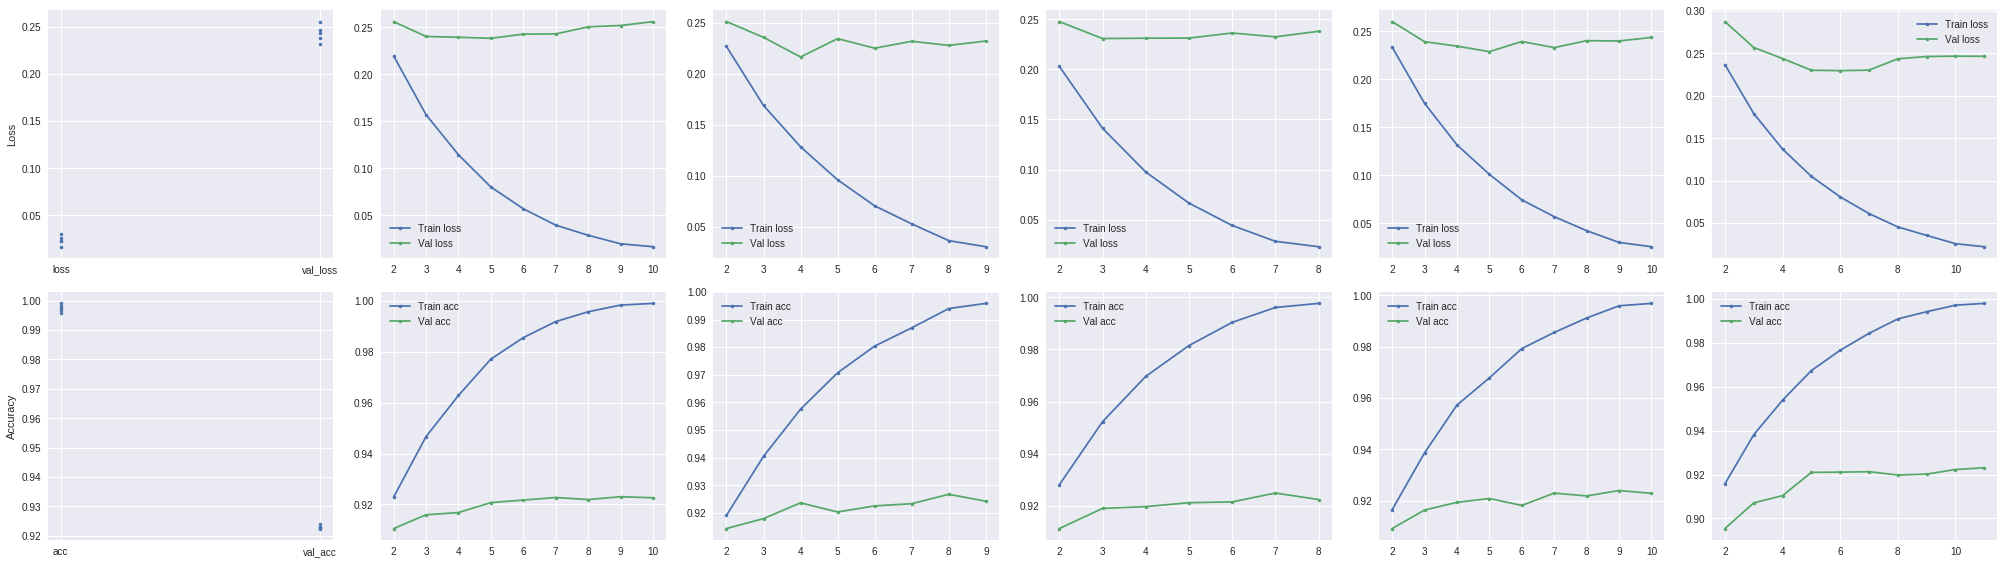

In [38]:
%%time

def make_model(x):
    model = Sequential()
    model.add(Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, 5, activation='relu'))
    model.add(BatchNormalization())    
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(10, activation='softmax'))
    
    return model

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]

train(make_model, optimizer=lambda: Adam(decay=0.01), callbacks=callbacks, verbose=1);

### Trial 11
Add more Conv2D

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 23, 23, 32)        16416     
_________________________________________________________________
batch_normalization_5 (Batch (None, 23, 23, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 19, 19, 32)        25632     
_________________________________________________________________
batch_normalization_6 (Batch (None, 19, 19, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 19, 32)        0         
__________

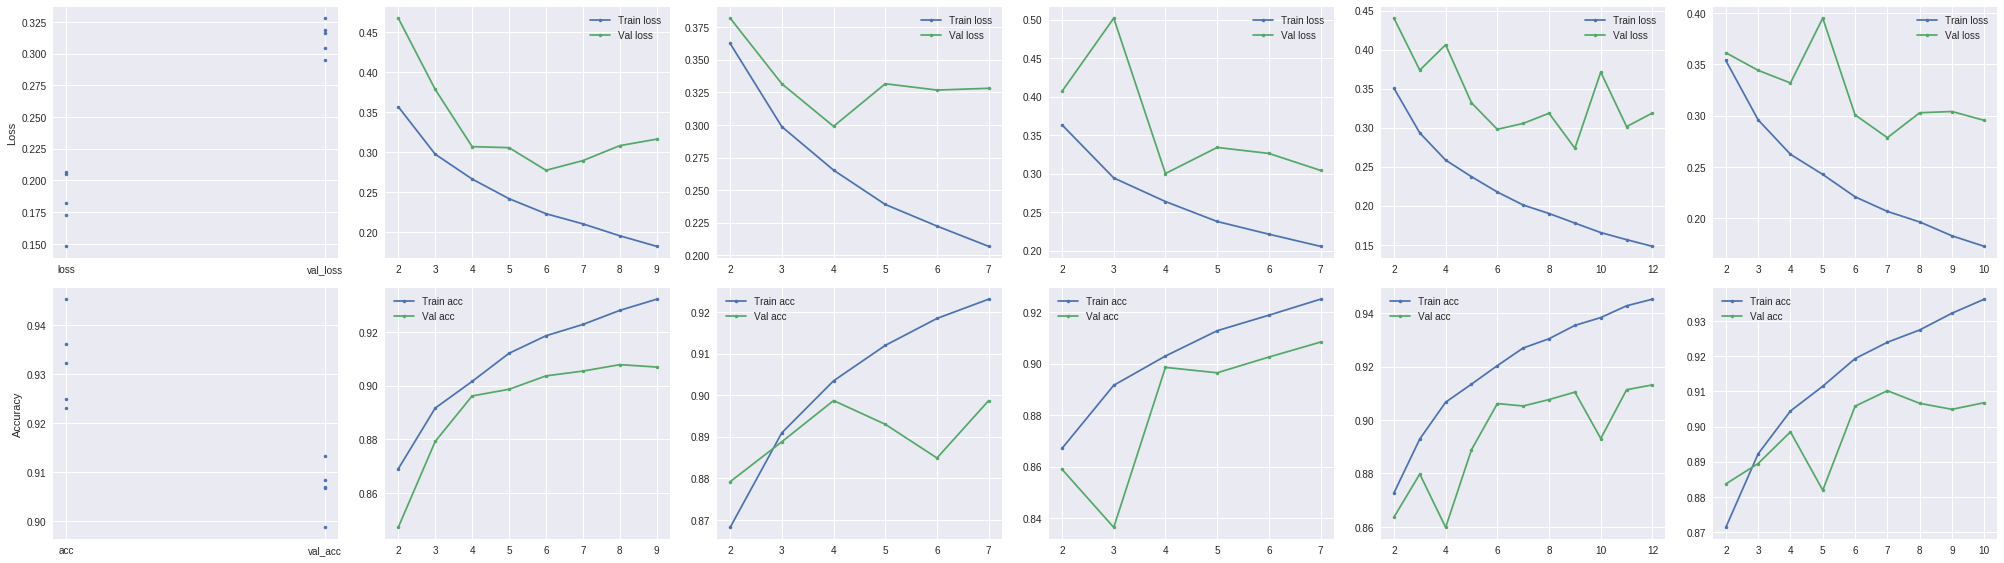

In [10]:
# More Conv2D
%%time

def make_model(x):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(make_model);

### Trial 12
Use SeparableConv2D



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 26, 26, 32)        73        
_________________________________________________________________
batch_normalization_10 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 23, 23, 32)        1568      
_________________________________________________________________
batch_normalization_11 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 19, 19, 32)        1856      
_________________________________________________________________
batch_normalization_12 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 19, 19, 32)        0         
__________

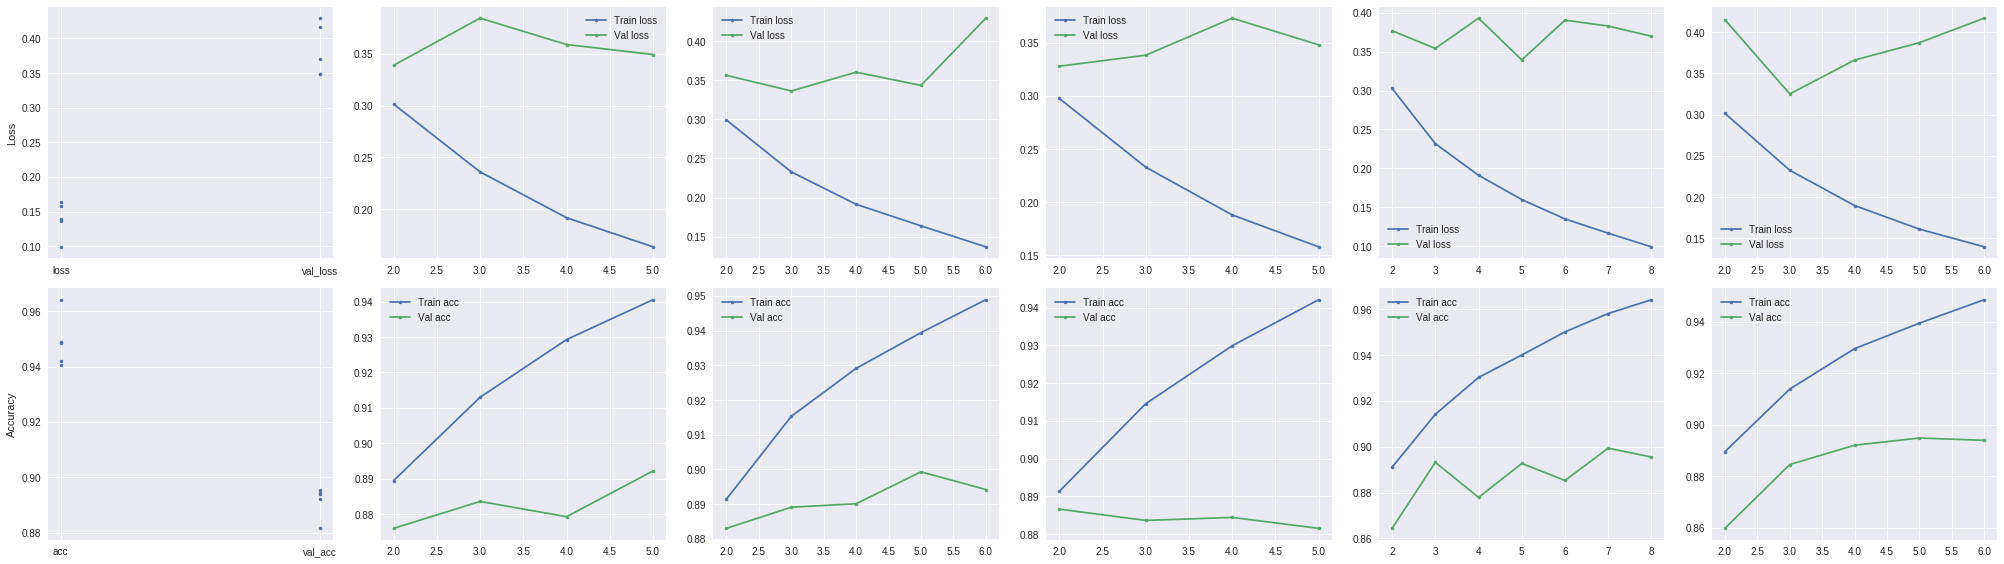

In [11]:
# Use SeparableConv2D
%%time

def make_model(x):
    model = Sequential()
    model.add(SeparableConv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(model);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_4 (Separabl (None, 26, 26, 32)        73        
_________________________________________________________________
batch_normalization_13 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 23, 23, 32)        1568      
_________________________________________________________________
batch_normalization_14 (Batc (None, 23, 23, 32)        128       
_________________________________________________________________
separable_conv2d_6 (Separabl (None, 19, 19, 32)        1856      
_________________________________________________________________
batch_normalization_15 (Batc (None, 19, 19, 32)        128       
_________________________________________________________________
flatten_7 (Flatten)          (None, 11552)             0         
__________

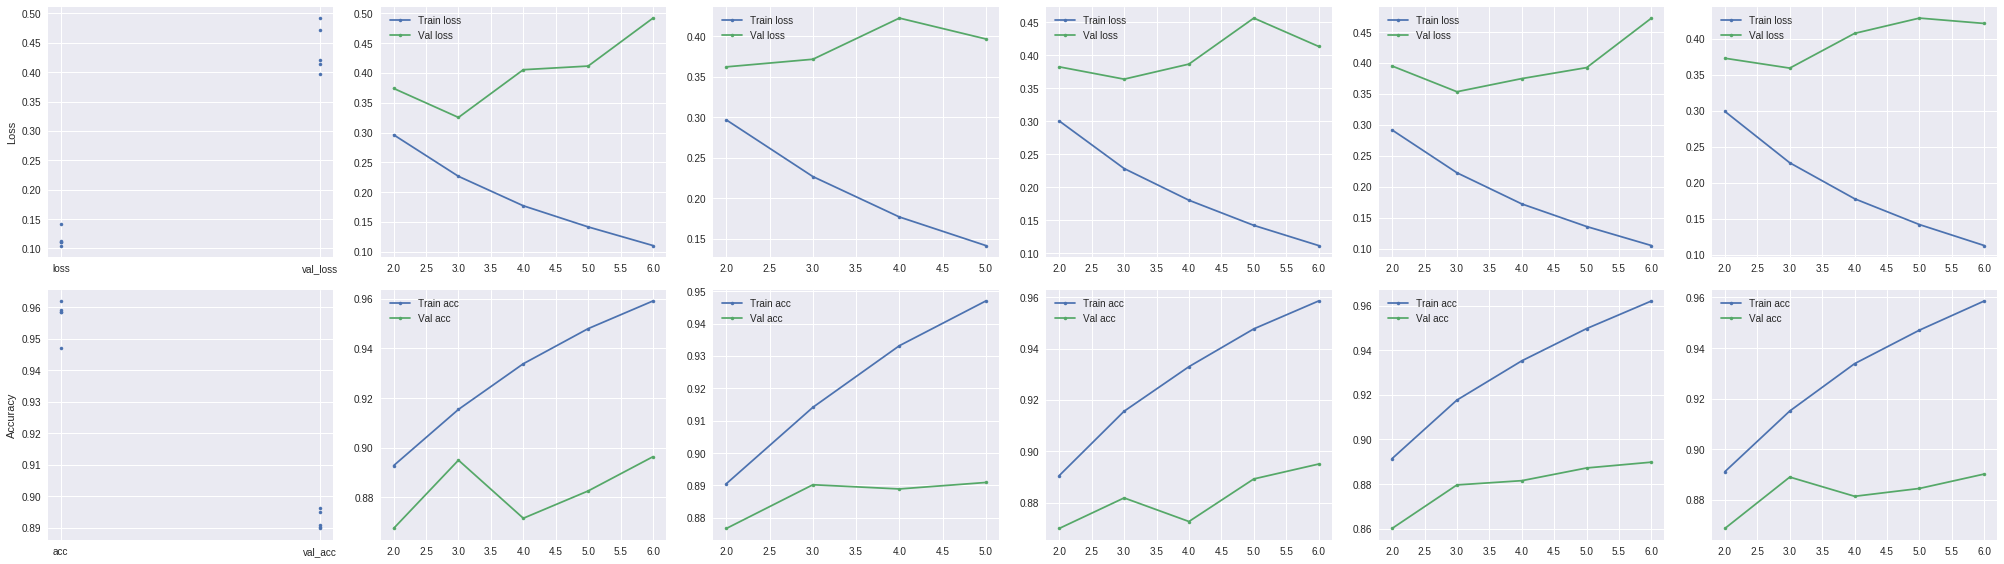

In [12]:
%%time

def make_model(x):
    model = Sequential()
    model.add(SeparableConv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=4, activation='relu'))
    model.add(BatchNormalization())
    model.add(SeparableConv2D(32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(model);

### Trial 13

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 512)         819712    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
__________

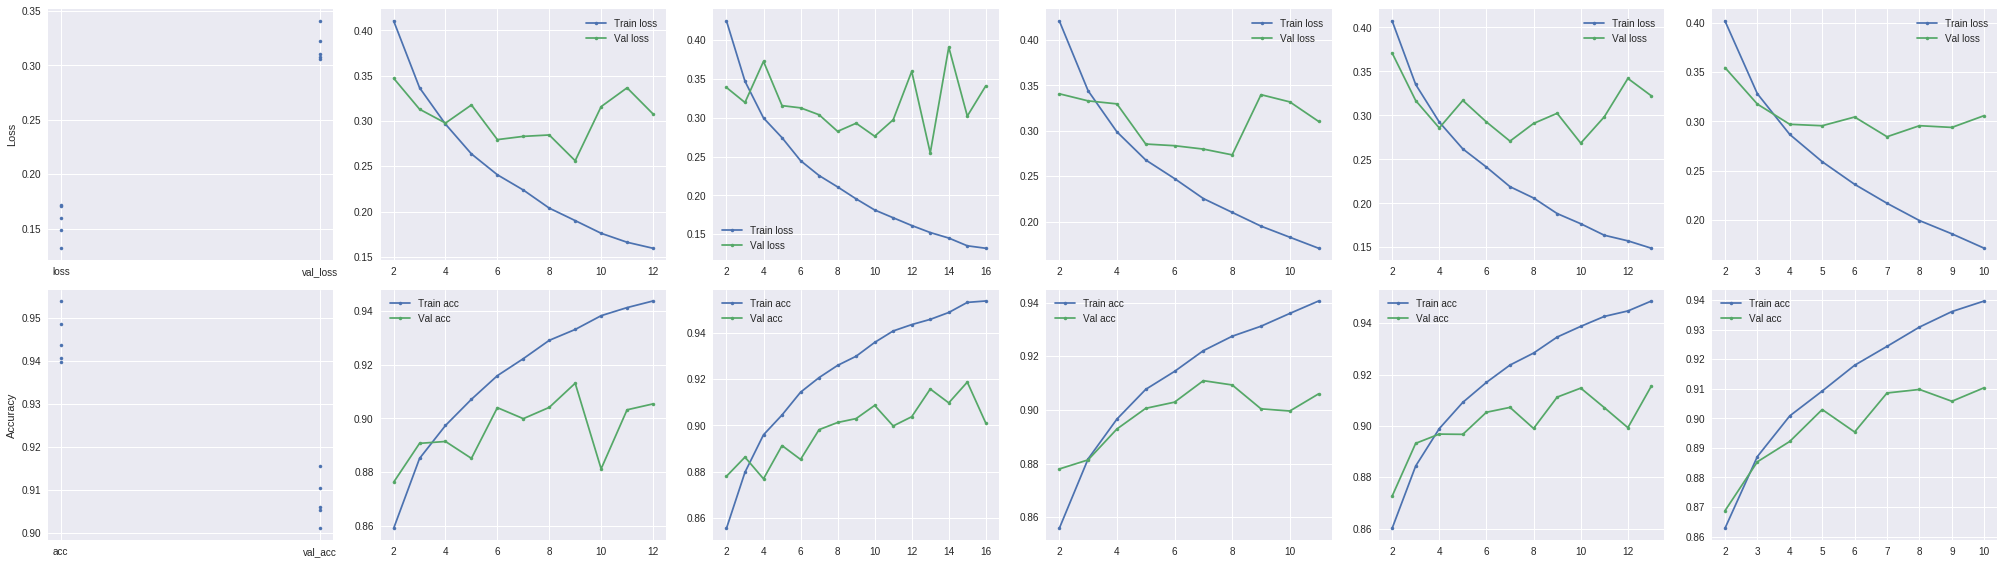

In [15]:
%%time

def make_model(x):
    model = Sequential()
    model.add(Conv2D(64, 5, activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(512, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(make_model);

### Trial 14

Mean test accuracy is now ~0.93

After about 20 epochs, we see there is not much improvement in the test set.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
__________

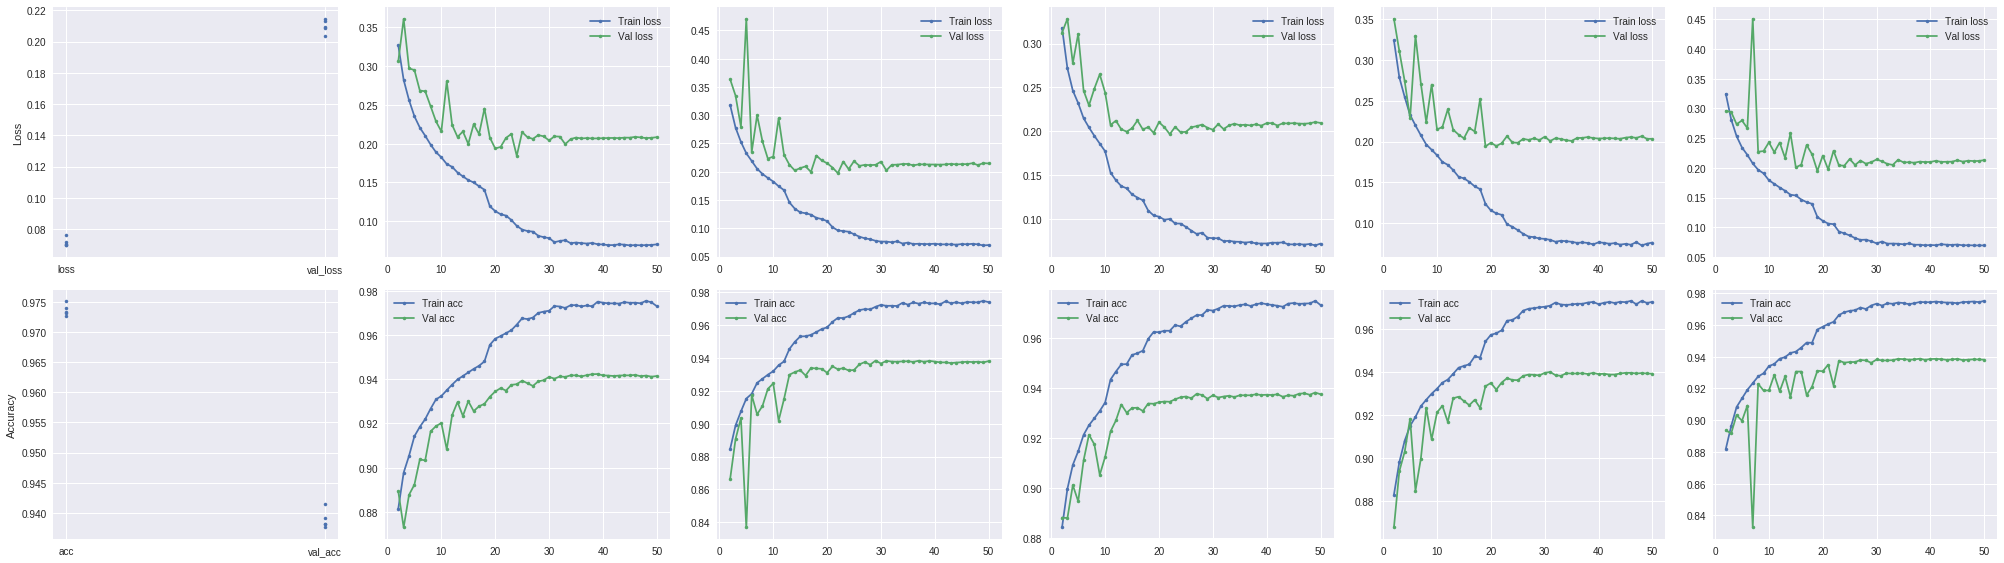

In [10]:
# https://github.com/khanguyen1207/My-Machine-Learning-Corner/blob/master/Zalando%20MNIST/fashion.ipynb
%%time

def make_model(i = None):
    model = Sequential()
    model.add(Conv2D(32, 5, padding='Same', activation='relu', input_shape=(28, 28, 1)))
    model.add(Conv2D(32, 5, padding='Same', activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(64, 3, padding='Same', activation='relu'))
    model.add(Conv2D(64, 3, padding='Same',activation='relu'))
    model.add(MaxPooling2D(strides=2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    return model

models, hists = train(make_model, callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=0, factor=0.5, min_lr=1e-5)], verbose=0)

### Trial 15

In [111]:
# https://github.com/Xfan1025/Fashion-MNIST/blob/master/fashion-mnist.ipynb

def make_model(x):
    model = Sequential()
    model.add(Conv2D(64, 5, activation='relu', input_shape=(28, 28, 1), bias_initializer='RandomNormal', kernel_initializer='random_uniform'))
    model.add(MaxPooling2D())
    model.add(Conv2D(512, 5, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(10, activation='softmax'))
    
    return model

train(make_model, optimizer=lambda: Adam(decay=0.01), callbacks=lambda: [ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5)], verbose=1);

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_155 (Conv2D)          (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_156 (Conv2D)          (None, 8, 8, 512)         819712    
_________________________________________________________________
max_pooling2d_99 (MaxPooling (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_70 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_153 (Dense)            (None, 128)               1048704   
_________________________________________________________________
dropout_164 (Dropout)        (None, 128)               0         
__________

KeyboardInterrupt: ignored

### Trial 16

In [0]:
# https://github.com/cmasch/zalando-fashion-mnist/blob/master/Simple_Convolutional_Neural_Network_Fashion-MNIST.ipynb
%%time

def make_model(x):
    model = Sequential()
    model.add(Conv2D(64, 4, padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Conv2D(64, 4, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='softmax'))
    
    return model

train(make_model, optimizer='adam', callbacks=lambda: []);